Ноутбук со всеми экспериментами

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from pandas.core import frame
import os
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import librosa
import math

1) Стандартная версия MOSNet без модификаций.

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
        reshaped_input = input_seq.contiguous().view(-1, input_seq.size(-1))
        output = self.module(reshaped_input)
        if self.batch_first:
            output = output.contiguous().view(input_seq.size(0), -1, output.size(-1))
        else:
            output = output.contiguous().view(-1, input_seq.size(1), output.size(-1))
        return output


class CNN_BLSTM(nn.Module):
    def __init__(self):
        super(CNN_BLSTM, self).__init__()
        # CNN
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 3), 1), nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 3), 1), nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 3), 1), nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 3), 1), nn.ReLU())
        # re_shape = layers.Reshape((-1, 4*128), input_shape=(-1, 4, 128))(conv4)
        self.blstm1 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.droupout = nn.Dropout(0.3)
        # FC
        self.flatten = TimeDistributed(nn.Flatten(), batch_first=True)
        self.dense1 = nn.Sequential(
            TimeDistributed(nn.Sequential(nn.Linear(in_features=256, out_features=128), nn.ReLU()), batch_first=True),
            nn.Dropout(0.3))

        # frame score
        self.frame_layer = TimeDistributed(nn.Linear(128, 1), batch_first=True)
        # avg score
        self.average_layer = nn.AdaptiveAvgPool1d(1)


    def forward(self, forward_input):
        conv1_output = self.conv1(forward_input)
        conv2_output = self.conv2(conv1_output)
        conv3_output = self.conv3(conv2_output)
        conv4_output = self.conv4(conv3_output)
        # reshape
        conv4_output = conv4_output.permute(0, 2, 1, 3)
        conv4_output = torch.reshape(conv4_output, (conv4_output.shape[0], conv4_output.shape[1], 4 * 128))

        # blstm
        blstm_output, (h_n, c_n) = self.blstm1(conv4_output)
        blstm_output = self.droupout(blstm_output)

        flatten_output = self.flatten(blstm_output)
        fc_output = self.dense1(flatten_output)
        frame_score = self.frame_layer(fc_output)

        avg_score = self.average_layer(frame_score.permute(0, 2, 1))
        return torch.reshape(avg_score, (avg_score.shape[0], -1)), frame_score

In [ ]:
class MOSDataset(Dataset):
    def __init__(self, audio_dir, txt_path, sample_rate=16000, fft_size=512, hop_length=256, win_length=512):

        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.data = self._parse_txt_file(txt_path)

    def _parse_txt_file(self, txt_path):
        data = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()[1:]
                for line in lines:
                    parts = line.strip().split(',')
                    utterance_id = parts[1].strip()
                    mean_score = float(parts[2].strip())

                    wav_path = os.path.join(self.audio_dir, utterance_id)
                    if os.path.exists(wav_path):
                        data.append((utterance_id, mean_score))
        return data

    def __len__(self):
        return len(self.data)

    def get_spectrogram(self, wav_path):
        #:return: Torch тензор спектрограммы (1, T, F).
        if not os.path.exists(wav_path):
            return None
        y, _ = librosa.load(wav_path, sr=self.sample_rate)

        linear = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
        mag = np.abs(linear).astype(np.float32)

        # (T, F) -> (1, T, F)
        mag = np.expand_dims(mag.T, axis=0)
        return torch.tensor(mag)

    def __getitem__(self, idx):
        #:return: tuple(spectrogram, MOS)
        utterance_id, mos_score = self.data[idx]
        wav_path = os.path.join(self.audio_dir, utterance_id)
        spectrogram = self.get_spectrogram(wav_path)
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        return spectrogram, mos_score


def collate_fn(batch):
    #:return: padded spectrogram tensor, MOS tensor
    spectrograms, mos_scores = zip(*batch)
    # max time len
    max_len = max(spectrogram.shape[1] for spectrogram in spectrograms)

    padded_spectrograms = torch.zeros(len(spectrograms), 1, max_len, spectrograms[0].shape[2])
    for i, spectrogram in enumerate(spectrograms):
        padded_spectrograms[i, :, :spectrogram.shape[1], :] = spectrogram

    mos_scores = torch.stack(mos_scores)

    return padded_spectrograms, mos_scores

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MOSDataset(
        audio_dir="audios",
        txt_path="training_files/split1/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
'''
for batch in dataloader:
    spectrograms, mos_scores = batch
    #print("Spectrograms shape:", spectrograms.shape)  # [batch_size, 1, T, F]
    #print("MOS scores shape:", mos_scores.shape)  # [batch_size, 1]
'''

'\nfor batch in dataloader:\n    spectrograms, mos_scores = batch\n    #print("Spectrograms shape:", spectrograms.shape)  # [batch_size, 1, T, F]\n    #print("MOS scores shape:", mos_scores.shape)  # [batch_size, 1]\n'

In [ ]:
test_dataset = MOSDataset(
        audio_dir="audios",
        txt_path="training_files/split1/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for spectrograms, mos_scores in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            mos_scores = mos_scores.to(device)
            avg_scores, _ = model(spectrograms)
            loss = criterion(avg_scores, mos_scores)
            total_loss += loss.item() * spectrograms.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:13<00:00,  3.88it/s]


Epoch 1/20 - Train Loss: 0.4172 - Val Loss: 0.3215


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:06<00:00,  4.02it/s]


Epoch 2/20 - Train Loss: 0.3186 - Val Loss: 0.3168


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:05<00:00,  4.04it/s]


Epoch 3/20 - Train Loss: 0.3094 - Val Loss: 0.3074


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:00<00:00,  4.15it/s]


Epoch 4/20 - Train Loss: 0.3009 - Val Loss: 0.2996


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.24it/s]


Epoch 5/20 - Train Loss: 0.2933 - Val Loss: 0.2937


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.30it/s]


Epoch 6/20 - Train Loss: 0.2906 - Val Loss: 0.2894


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:01<00:00,  4.14it/s]


Epoch 7/20 - Train Loss: 0.2871 - Val Loss: 0.3004


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:00<00:00,  4.16it/s]


Epoch 8/20 - Train Loss: 0.2834 - Val Loss: 0.3030


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:57<00:00,  4.23it/s]


Epoch 9/20 - Train Loss: 0.2829 - Val Loss: 0.2850


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:51<00:00,  4.37it/s]


Epoch 10/20 - Train Loss: 0.2819 - Val Loss: 0.3000


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 11/20 - Train Loss: 0.2808 - Val Loss: 0.3000


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.29it/s]


Epoch 12/20 - Train Loss: 0.2785 - Val Loss: 0.2824


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:49<00:00,  4.42it/s]


Epoch 13/20 - Train Loss: 0.2788 - Val Loss: 0.2846


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.26it/s]


Epoch 14/20 - Train Loss: 0.2779 - Val Loss: 0.2804


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:52<00:00,  4.34it/s]


Epoch 15/20 - Train Loss: 0.2743 - Val Loss: 0.2801


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 16/20 - Train Loss: 0.2732 - Val Loss: 0.2780


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 17/20 - Train Loss: 0.2731 - Val Loss: 0.2844


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:51<00:00,  4.37it/s]


Epoch 18/20 - Train Loss: 0.2703 - Val Loss: 0.2742


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:50<00:00,  4.40it/s]


Epoch 19/20 - Train Loss: 0.2711 - Val Loss: 0.2921


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 20/20 - Train Loss: 0.2717 - Val Loss: 0.2854


In [ ]:
print(len(train_dataset), len(test_dataset))

14100 3000


In [ ]:
file_path = "training_files/split1/clean/train_mos_list.txt"
with open(file_path, 'r') as file:
    line_count = sum(1 for _ in file)
print(f"Количество строк в файле: {line_count}")

Количество строк в файле: 19075


In [ ]:
file_path = "training_files/split1/clean/test_mos_list.txt"
with open(file_path, 'r') as file:
    line_count = sum(1 for _ in file)
print(f"Количество строк в файле: {line_count}")

Количество строк в файле: 4067


1) Отсортить по длине аудиозаписи для более хороших батчей(идея с NLP), подумать насчет паддинга(маска..?)
2) Текст пропустить через предобученную модель, объединить со звуковым представлением перед последним FC слоем
3) То же самое, но объединить перед BLSTM слоем
4) Что-то типа cross attention:)
5) Также потестить MeanNet, (добавить Norm + Dropout)

Попробуем слои MBNet - в частности, MeanNet

2) MeanNet = MOSNET + nn.Dropout(0.3), nn.BatchNorm2d(out_channels) (??? дропаут до батчнорма)

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
        reshaped_input = input_seq.contiguous().view(-1, input_seq.size(-1))
        output = self.module(reshaped_input)
        if self.batch_first:
            output = output.contiguous().view(input_seq.size(0), -1, output.size(-1))
        else:
            output = output.contiguous().view(-1, input_seq.size(1), output.size(-1))
        return output


class CNN_BLSTM_MBNET(nn.Module):
    def __init__(self):
        super(CNN_BLSTM_MBNET, self).__init__()
        # CNN
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm2d(32)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm2d(64)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm2d(128)
        )
        # re_shape = layers.Reshape((-1, 4*128), input_shape=(-1, 4, 128))(conv4)
        self.blstm1 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.droupout = nn.Dropout(0.3)
        # FC
        self.flatten = TimeDistributed(nn.Flatten(), batch_first=True)
        self.dense1 = nn.Sequential(
            TimeDistributed(nn.Sequential(nn.Linear(in_features=256, out_features=128), nn.ReLU()), batch_first=True),
            nn.Dropout(0.3))

        # frame score
        self.frame_layer = TimeDistributed(nn.Linear(128, 1), batch_first=True)
        # avg score
        self.average_layer = nn.AdaptiveAvgPool1d(1)


    def forward(self, forward_input):
        conv1_output = self.conv1(forward_input)
        conv2_output = self.conv2(conv1_output)
        conv3_output = self.conv3(conv2_output)
        conv4_output = self.conv4(conv3_output)
        # reshape
        conv4_output = conv4_output.permute(0, 2, 1, 3)
        conv4_output = torch.reshape(conv4_output, (conv4_output.shape[0], conv4_output.shape[1], 4 * 128))

        # blstm
        blstm_output, (h_n, c_n) = self.blstm1(conv4_output)
        blstm_output = self.droupout(blstm_output)

        flatten_output = self.flatten(blstm_output)
        fc_output = self.dense1(flatten_output)
        frame_score = self.frame_layer(fc_output)

        avg_score = self.average_layer(frame_score.permute(0, 2, 1))
        return torch.reshape(avg_score, (avg_score.shape[0], -1)), frame_score

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [04:29<00:00,  2.78it/s]


Epoch 1/20 - Train Loss: 0.3499 - Val Loss: 0.4568


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:24<00:00,  3.67it/s]


Epoch 2/20 - Train Loss: 0.2762 - Val Loss: 0.3618


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:24<00:00,  3.66it/s]


Epoch 3/20 - Train Loss: 0.2658 - Val Loss: 0.5620


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:18<00:00,  3.77it/s]


Epoch 4/20 - Train Loss: 0.2607 - Val Loss: 0.3276


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:33<00:00,  3.51it/s]


Epoch 5/20 - Train Loss: 0.2570 - Val Loss: 0.3090


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:37<00:00,  3.45it/s]


Epoch 6/20 - Train Loss: 0.2574 - Val Loss: 0.3983


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:20<00:00,  3.75it/s]


Epoch 7/20 - Train Loss: 0.2512 - Val Loss: 0.2733


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:38<00:00,  3.44it/s]


Epoch 8/20 - Train Loss: 0.2492 - Val Loss: 0.2947


Validation: 100%|█████████████████████████████████████████████████████████| 750/750 [7:57:06<00:00, 38.17s/it]


Epoch 9/20 - Train Loss: 0.2477 - Val Loss: 0.2826


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 10/20 - Train Loss: 0.2442 - Val Loss: 0.2595


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.30it/s]


Epoch 11/20 - Train Loss: 0.2415 - Val Loss: 0.2517


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.28it/s]


Epoch 12/20 - Train Loss: 0.2386 - Val Loss: 0.2598


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.33it/s]


Epoch 13/20 - Train Loss: 0.2354 - Val Loss: 0.2750


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.29it/s]


Epoch 14/20 - Train Loss: 0.2347 - Val Loss: 0.2481


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:52<00:00,  4.34it/s]


Epoch 15/20 - Train Loss: 0.2337 - Val Loss: 0.2510


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.25it/s]


Epoch 16/20 - Train Loss: 0.2321 - Val Loss: 0.2434


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 17/20 - Train Loss: 0.2288 - Val Loss: 0.2847


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:52<00:00,  4.34it/s]


Epoch 18/20 - Train Loss: 0.2255 - Val Loss: 0.2441


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.30it/s]


Epoch 19/20 - Train Loss: 0.2242 - Val Loss: 0.2394


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:51<00:00,  4.38it/s]

Epoch 20/20 - Train Loss: 0.2217 - Val Loss: 0.2405


In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
        reshaped_input = input_seq.contiguous().view(-1, input_seq.size(-1))
        output = self.module(reshaped_input)
        if self.batch_first:
            output = output.contiguous().view(input_seq.size(0), -1, output.size(-1))
        else:
            output = output.contiguous().view(-1, input_seq.size(1), output.size(-1))
        return output


class CNN_BLSTM_MBNET2(nn.Module):
    def __init__(self, dropout = 0.3):
        super(CNN_BLSTM_MBNET2, self).__init__()
        # CNN
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout)
        )
        # re_shape = layers.Reshape((-1, 4*128), input_shape=(-1, 4, 128))(conv4)
        self.blstm1 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.droupout = nn.Dropout(dropout)
        # FC
        self.flatten = TimeDistributed(nn.Flatten(), batch_first=True)
        self.dense1 = nn.Sequential(
            TimeDistributed(nn.Sequential(nn.Linear(in_features=256, out_features=128), nn.ReLU()), batch_first=True),
            nn.Dropout(dropout))

        # frame score
        self.frame_layer = TimeDistributed(nn.Linear(128, 1), batch_first=True)
        # avg score
        self.average_layer = nn.AdaptiveAvgPool1d(1)


    def forward(self, forward_input):
        conv1_output = self.conv1(forward_input)
        conv2_output = self.conv2(conv1_output)
        conv3_output = self.conv3(conv2_output)
        conv4_output = self.conv4(conv3_output)
        # reshape
        conv4_output = conv4_output.permute(0, 2, 1, 3)
        conv4_output = torch.reshape(conv4_output, (conv4_output.shape[0], conv4_output.shape[1], 4 * 128))

        # blstm
        blstm_output, (h_n, c_n) = self.blstm1(conv4_output)
        blstm_output = self.droupout(blstm_output)

        flatten_output = self.flatten(blstm_output)
        fc_output = self.dense1(flatten_output)
        frame_score = self.frame_layer(fc_output)

        avg_score = self.average_layer(frame_score.permute(0, 2, 1))
        return torch.reshape(avg_score, (avg_score.shape[0], -1)), frame_score

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2(dropout = 0.3).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:57<00:00,  4.23it/s]


Epoch 1/20 - Train Loss: 0.3516 - Val Loss: 0.2954


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:01<00:00,  4.14it/s]


Epoch 2/20 - Train Loss: 0.2772 - Val Loss: 0.2842


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:04<00:00,  4.06it/s]


Epoch 3/20 - Train Loss: 0.2641 - Val Loss: 0.2772


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:52<00:00,  4.34it/s]


Epoch 4/20 - Train Loss: 0.2588 - Val Loss: 0.2719


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:59<00:00,  4.17it/s]


Epoch 5/20 - Train Loss: 0.2562 - Val Loss: 0.2649


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:00<00:00,  4.16it/s]


Epoch 6/20 - Train Loss: 0.2507 - Val Loss: 0.2997


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.29it/s]


Epoch 7/20 - Train Loss: 0.2484 - Val Loss: 0.2920


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:52<00:00,  4.34it/s]


Epoch 8/20 - Train Loss: 0.2467 - Val Loss: 0.2636


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:58<00:00,  4.20it/s]


Epoch 9/20 - Train Loss: 0.2449 - Val Loss: 0.2996


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.33it/s]


Epoch 10/20 - Train Loss: 0.2431 - Val Loss: 0.2992


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.27it/s]


Epoch 11/20 - Train Loss: 0.2418 - Val Loss: 0.4586


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.27it/s]


Epoch 12/20 - Train Loss: 0.2382 - Val Loss: 0.2855


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.24it/s]


Epoch 13/20 - Train Loss: 0.2387 - Val Loss: 0.2479


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.26it/s]


Epoch 14/20 - Train Loss: 0.2341 - Val Loss: 0.2543


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.26it/s]


Epoch 15/20 - Train Loss: 0.2337 - Val Loss: 0.2611


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.28it/s]


Epoch 16/20 - Train Loss: 0.2311 - Val Loss: 0.2444


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.27it/s]


Epoch 17/20 - Train Loss: 0.2303 - Val Loss: 0.2542


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:59<00:00,  4.17it/s]


Epoch 18/20 - Train Loss: 0.2271 - Val Loss: 0.2528


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.31it/s]


Epoch 19/20 - Train Loss: 0.2253 - Val Loss: 0.2413


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.29it/s]


Epoch 20/20 - Train Loss: 0.2251 - Val Loss: 0.2842


In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2(dropout = 0.2).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:57<00:00,  4.22it/s]


Epoch 1/20 - Train Loss: 0.3503 - Val Loss: 0.2958


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.24it/s]


Epoch 2/20 - Train Loss: 0.2762 - Val Loss: 0.4920


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:59<00:00,  4.18it/s]


Epoch 3/20 - Train Loss: 0.2647 - Val Loss: 0.3249


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.26it/s]


Epoch 4/20 - Train Loss: 0.2558 - Val Loss: 0.2851


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:01<00:00,  4.14it/s]


Epoch 5/20 - Train Loss: 0.2558 - Val Loss: 0.2554


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.26it/s]


Epoch 6/20 - Train Loss: 0.2508 - Val Loss: 0.2580


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.32it/s]


Epoch 7/20 - Train Loss: 0.2469 - Val Loss: 0.2744


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.29it/s]


Epoch 8/20 - Train Loss: 0.2428 - Val Loss: 0.2697


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:57<00:00,  4.23it/s]


Epoch 9/20 - Train Loss: 0.2386 - Val Loss: 0.2531


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.28it/s]


Epoch 10/20 - Train Loss: 0.2380 - Val Loss: 0.2480


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:51<00:00,  4.36it/s]


Epoch 11/20 - Train Loss: 0.2324 - Val Loss: 0.2567


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.31it/s]


Epoch 12/20 - Train Loss: 0.2312 - Val Loss: 0.2861


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.26it/s]


Epoch 13/20 - Train Loss: 0.2295 - Val Loss: 0.3182


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.27it/s]


Epoch 14/20 - Train Loss: 0.2257 - Val Loss: 0.2464


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:58<00:00,  4.21it/s]


Epoch 15/20 - Train Loss: 0.2229 - Val Loss: 0.2489


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:54<00:00,  4.29it/s]


Epoch 16/20 - Train Loss: 0.2206 - Val Loss: 0.3844


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:51<00:00,  4.37it/s]


Epoch 17/20 - Train Loss: 0.2178 - Val Loss: 0.2745


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:55<00:00,  4.28it/s]


Epoch 18/20 - Train Loss: 0.2147 - Val Loss: 0.2779


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:53<00:00,  4.33it/s]


Epoch 19/20 - Train Loss: 0.2125 - Val Loss: 0.2692


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.24it/s]


Epoch 20/20 - Train Loss: 0.2129 - Val Loss: 0.2835


1. Послушать войс и попредиктить для моделей
2. Отсортить и потестить на датасете покрупнее
3. Реализовать маску) и потестить на датасете покрупнее

In [ ]:
wav_path = "audios/LJ002-0181_033.wav"
y, _ = librosa.load(wav_path, sr=16000)
linear = librosa.stft(y, n_fft=512, hop_length=256, win_length=512)
mag = np.abs(linear).astype(np.float32)
mag = np.expand_dims(mag.T, axis=0)
mag = torch.tensor(mag)
mag = mag.unsqueeze(0)
print(mag.shape)
#ans = 3.625
mag = mag.to("cuda")
ans, _ = model(mag)
print(ans)

torch.Size([1, 1, 530, 257])
tensor([[3.4259]], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
from IPython.display import Audio
wav_path = "audios/LJ002-0181_033.wav"
Audio(wav_path)

Сортировка:

In [ ]:
class MOSDataset(Dataset):
    def __init__(self, audio_dir, txt_path, sample_rate=16000, fft_size=512, hop_length=256, win_length=512):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.data = self._parse_txt_file(txt_path)

    def _parse_txt_file(self, txt_path):
        data = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()[1:]
                for line in lines:
                    parts = line.strip().split(',')
                    utterance_id = parts[1].strip()
                    mean_score = float(parts[2].strip())

                    wav_path = os.path.join(self.audio_dir, utterance_id)
                    if os.path.exists(wav_path):
                        # Определение длительности аудио
                        y, _ = librosa.load(wav_path, sr=self.sample_rate)
                        duration = len(y) / self.sample_rate
                        data.append((utterance_id, mean_score, duration))

        # Сортировка по длительности
        data.sort(key=lambda x: x[2])
        return [(d[0], d[1]) for d in data]

    def __len__(self):
        return len(self.data)

    def get_spectrogram(self, wav_path):
        if not os.path.exists(wav_path):
            return None
        y, _ = librosa.load(wav_path, sr=self.sample_rate)

        linear = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
        mag = np.abs(linear).astype(np.float32)

        # (T, F) -> (1, T, F)
        mag = np.expand_dims(mag.T, axis=0)
        return torch.tensor(mag)

    def __getitem__(self, idx):
        utterance_id, mos_score = self.data[idx]
        wav_path = os.path.join(self.audio_dir, utterance_id)
        spectrogram = self.get_spectrogram(wav_path)
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        return spectrogram, mos_score


тут collate_fn такая же, как выше:

In [ ]:
def collate_fn(batch):
    #:return: padded spectrogram tensor, MOS tensor
    spectrograms, mos_scores = zip(*batch)
    # max time len
    max_len = max(spectrogram.shape[1] for spectrogram in spectrograms)

    padded_spectrograms = torch.zeros(len(spectrograms), 1, max_len, spectrograms[0].shape[2])
    for i, spectrogram in enumerate(spectrograms):
        padded_spectrograms[i, :, :spectrogram.shape[1], :] = spectrogram

    mos_scores = torch.stack(mos_scores)

    return padded_spectrograms, mos_scores

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MOSDataset(
        audio_dir="audios",
        txt_path="training_files/split1/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

'\nfor batch in dataloader:\n    spectrograms, mos_scores = batch\n    #print("Spectrograms shape:", spectrograms.shape)  # [batch_size, 1, T, F]\n    #print("MOS scores shape:", mos_scores.shape)  # [batch_size, 1]\n'

In [ ]:
test_dataset = MOSDataset(
        audio_dir="audios",
        txt_path="training_files/split1/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2(dropout = 0.2).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2.pt'))

Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:29<00:00,  3.58it/s]


Epoch 1/20 - Train Loss: 0.3345 - Val Loss: 0.2824


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:31<00:00,  3.55it/s]


Epoch 2/20 - Train Loss: 0.2706 - Val Loss: 0.4266


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:27<00:00,  3.62it/s]


Epoch 3/20 - Train Loss: 0.2628 - Val Loss: 0.2778


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:24<00:00,  3.67it/s]


Epoch 4/20 - Train Loss: 0.2558 - Val Loss: 0.2757


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:20<00:00,  3.75it/s]


Epoch 5/20 - Train Loss: 0.2523 - Val Loss: 0.3640


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:23<00:00,  3.69it/s]


Epoch 6/20 - Train Loss: 0.2480 - Val Loss: 0.2563


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [04:35<00:00,  2.73it/s]


Epoch 7/20 - Train Loss: 0.2429 - Val Loss: 0.2898


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [04:23<00:00,  2.85it/s]


Epoch 8/20 - Train Loss: 0.2400 - Val Loss: 0.2660


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:26<00:00,  3.64it/s]


Epoch 9/20 - Train Loss: 0.2378 - Val Loss: 0.2643


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:29<00:00,  3.59it/s]


Epoch 10/20 - Train Loss: 0.2356 - Val Loss: 0.2656


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:12<00:00,  3.90it/s]


Epoch 11/20 - Train Loss: 0.2351 - Val Loss: 0.2631


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:22<00:00,  3.70it/s]


Epoch 12/20 - Train Loss: 0.2299 - Val Loss: 0.2452


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:13<00:00,  3.88it/s]


Epoch 13/20 - Train Loss: 0.2286 - Val Loss: 0.2753


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:18<00:00,  3.78it/s]


Epoch 14/20 - Train Loss: 0.2246 - Val Loss: 0.2463


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:11<00:00,  3.92it/s]


Epoch 15/20 - Train Loss: 0.2262 - Val Loss: 0.2832


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:13<00:00,  3.87it/s]


Epoch 16/20 - Train Loss: 0.2198 - Val Loss: 0.2475


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:13<00:00,  3.88it/s]


Epoch 17/20 - Train Loss: 0.2179 - Val Loss: 0.3445


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:02<00:00,  4.11it/s]


Epoch 18/20 - Train Loss: 0.2165 - Val Loss: 0.3114


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:02<00:00,  4.11it/s]


Epoch 19/20 - Train Loss: 0.2130 - Val Loss: 0.2402


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:13<00:00,  3.87it/s]


Epoch 20/20 - Train Loss: 0.2093 - Val Loss: 0.2623


RuntimeError: Parent directory IMSH does not exist.

In [ ]:
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2.pt'))

Проверим отсорченный сет + дропаут(0.3) + батчнорм

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET.pt'))

Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:59<00:00,  4.18it/s]


Epoch 1/20 - Train Loss: 0.3576 - Val Loss: 0.3997


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:07<00:00,  3.99it/s]


Epoch 2/20 - Train Loss: 0.2825 - Val Loss: 0.3534


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:06<00:00,  4.03it/s]


Epoch 3/20 - Train Loss: 0.2672 - Val Loss: 0.3916


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:07<00:00,  4.00it/s]


Epoch 4/20 - Train Loss: 0.2615 - Val Loss: 0.3054


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:05<00:00,  4.05it/s]


Epoch 5/20 - Train Loss: 0.2608 - Val Loss: 0.4704


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:11<00:00,  3.91it/s]


Epoch 6/20 - Train Loss: 0.2551 - Val Loss: 0.2835


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:12<00:00,  3.89it/s]


Epoch 7/20 - Train Loss: 0.2521 - Val Loss: 0.3236


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:17<00:00,  3.79it/s]


Epoch 8/20 - Train Loss: 0.2469 - Val Loss: 0.2861


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:18<00:00,  3.78it/s]


Epoch 9/20 - Train Loss: 0.2474 - Val Loss: 0.2983


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:12<00:00,  3.89it/s]


Epoch 10/20 - Train Loss: 0.2456 - Val Loss: 0.2560


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:59<00:00,  4.19it/s]


Epoch 11/20 - Train Loss: 0.2434 - Val Loss: 0.2518


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:04<00:00,  4.06it/s]


Epoch 12/20 - Train Loss: 0.2411 - Val Loss: 0.2539


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:57<00:00,  4.23it/s]


Epoch 13/20 - Train Loss: 0.2385 - Val Loss: 0.4475


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:05<00:00,  4.04it/s]


Epoch 14/20 - Train Loss: 0.2373 - Val Loss: 0.3010


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:58<00:00,  4.20it/s]


Epoch 15/20 - Train Loss: 0.2367 - Val Loss: 0.2628


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:02<00:00,  4.11it/s]


Epoch 16/20 - Train Loss: 0.2341 - Val Loss: 0.3300


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:51<00:00,  4.36it/s]


Epoch 17/20 - Train Loss: 0.2342 - Val Loss: 0.2729


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:04<00:00,  4.07it/s]


Epoch 18/20 - Train Loss: 0.2304 - Val Loss: 0.2547


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [02:56<00:00,  4.24it/s]


Epoch 19/20 - Train Loss: 0.2286 - Val Loss: 0.2454


Validation: 100%|███████████████████████████████████████████████████████████| 750/750 [03:03<00:00,  4.08it/s]

Epoch 20/20 - Train Loss: 0.2281 - Val Loss: 0.2470


Объединенный датасет

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
test_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
print(len(train_dataset), len(test_dataset))

16354 3741


In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2(dropout = 0.2).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2_bigger_set.pt'))

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:22<00:00,  4.62it/s]


Epoch 1/20 - Train Loss: 0.4130 - Val Loss: 0.4165


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:21<00:00,  4.64it/s]


Epoch 2/20 - Train Loss: 0.3328 - Val Loss: 0.3762


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:23<00:00,  4.60it/s]


Epoch 3/20 - Train Loss: 0.3109 - Val Loss: 0.3370


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:22<00:00,  4.62it/s]


Epoch 4/20 - Train Loss: 0.2981 - Val Loss: 0.3308


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 5/20 - Train Loss: 0.2893 - Val Loss: 0.3226


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.96it/s]


Epoch 6/20 - Train Loss: 0.2813 - Val Loss: 0.3513


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:09<00:00,  4.95it/s]


Epoch 7/20 - Train Loss: 0.2759 - Val Loss: 0.3025


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.97it/s]


Epoch 8/20 - Train Loss: 0.2695 - Val Loss: 0.3969


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.86it/s]


Epoch 9/20 - Train Loss: 0.2648 - Val Loss: 0.2951


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 10/20 - Train Loss: 0.2614 - Val Loss: 0.3426


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 11/20 - Train Loss: 0.2546 - Val Loss: 0.3134


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 12/20 - Train Loss: 0.2515 - Val Loss: 0.2822


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 13/20 - Train Loss: 0.2467 - Val Loss: 0.2702


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.96it/s]


Epoch 14/20 - Train Loss: 0.2428 - Val Loss: 0.3147


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 15/20 - Train Loss: 0.2365 - Val Loss: 0.3493


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.92it/s]


Epoch 16/20 - Train Loss: 0.2354 - Val Loss: 0.3132


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.90it/s]


Epoch 17/20 - Train Loss: 0.2318 - Val Loss: 0.2688


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.97it/s]


Epoch 18/20 - Train Loss: 0.2297 - Val Loss: 0.2619


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:24<00:00,  4.57it/s]


Epoch 19/20 - Train Loss: 0.2250 - Val Loss: 0.3611


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:29<00:00,  4.48it/s]


Epoch 20/20 - Train Loss: 0.2230 - Val Loss: 0.3756


In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET_bigger_set.pt'))

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:28<00:00,  4.49it/s]


Epoch 1/20 - Train Loss: 0.4201 - Val Loss: 0.4659


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 2/20 - Train Loss: 0.3422 - Val Loss: 0.3839


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:09<00:00,  4.93it/s]


Epoch 3/20 - Train Loss: 0.3227 - Val Loss: 0.3845


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:06<00:00,  5.01it/s]


Epoch 4/20 - Train Loss: 0.3058 - Val Loss: 0.4011


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.80it/s]


Epoch 5/20 - Train Loss: 0.2977 - Val Loss: 0.3410


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:07<00:00,  4.99it/s]


Epoch 6/20 - Train Loss: 0.2904 - Val Loss: 0.3253


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.91it/s]


Epoch 7/20 - Train Loss: 0.2855 - Val Loss: 0.3429


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:03<00:00,  5.11it/s]


Epoch 8/20 - Train Loss: 0.2819 - Val Loss: 0.3112


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.97it/s]


Epoch 9/20 - Train Loss: 0.2765 - Val Loss: 0.3347


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:05<00:00,  5.04it/s]


Epoch 10/20 - Train Loss: 0.2694 - Val Loss: 0.3036


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.86it/s]


Epoch 11/20 - Train Loss: 0.2705 - Val Loss: 0.3272


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.98it/s]


Epoch 12/20 - Train Loss: 0.2658 - Val Loss: 0.3454


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.86it/s]


Epoch 13/20 - Train Loss: 0.2623 - Val Loss: 0.2921


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:06<00:00,  5.01it/s]


Epoch 14/20 - Train Loss: 0.2597 - Val Loss: 0.3093


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.80it/s]


Epoch 15/20 - Train Loss: 0.2560 - Val Loss: 0.2995


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:07<00:00,  5.00it/s]


Epoch 16/20 - Train Loss: 0.2554 - Val Loss: 0.4458


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.86it/s]


Epoch 17/20 - Train Loss: 0.2500 - Val Loss: 0.2816


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 18/20 - Train Loss: 0.2499 - Val Loss: 0.2785


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 19/20 - Train Loss: 0.2456 - Val Loss: 0.2791


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.92it/s]

Epoch 20/20 - Train Loss: 0.2442 - Val Loss: 0.2831


Маска:

In [ ]:
class MOSDataset(Dataset):
    def __init__(self, audio_dir, txt_path, sample_rate=16000, fft_size=512, hop_length=256, win_length=512):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.data = self._parse_txt_file(txt_path)

    def _parse_txt_file(self, txt_path):
        data = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()[1:]
                for line in lines:
                    parts = line.strip().split(',')
                    utterance_id = parts[1].strip()
                    mean_score = float(parts[2].strip())

                    wav_path = os.path.join(self.audio_dir, utterance_id)
                    if os.path.exists(wav_path):
                        # Определение длительности аудио
                        y, _ = librosa.load(wav_path, sr=self.sample_rate)
                        duration = len(y) / self.sample_rate
                        data.append((utterance_id, mean_score, duration))

        # Сортировка по длительности
        data.sort(key=lambda x: x[2])
        return [(d[0], d[1]) for d in data]

    def __len__(self):
        return len(self.data)

    def get_spectrogram(self, wav_path):
        if not os.path.exists(wav_path):
            return None
        y, _ = librosa.load(wav_path, sr=self.sample_rate)

        linear = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
        mag = np.abs(linear).astype(np.float32)

        # (T, F) -> (1, T, F)
        mag = np.expand_dims(mag.T, axis=0)
        return torch.tensor(mag)

    def __getitem__(self, idx):
        utterance_id, mos_score = self.data[idx]
        wav_path = os.path.join(self.audio_dir, utterance_id)
        spectrogram = self.get_spectrogram(wav_path)

        mask = torch.ones(spectrogram.shape[-2], dtype=torch.float32)
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        return spectrogram, mos_score, mask

In [ ]:
def collate_fn(batch):
    #:return: padded spectrogram tensor, MOS tensor, mask tensor
    spectrograms, mos_scores, masks = zip(*batch)  # Теперь учитываем третье значение

    # max time len
    max_len = max(spectrogram.shape[1] for spectrogram in spectrograms)

    # Создаем тензор для паддинга спектрограммы
    padded_spectrograms = torch.zeros(len(spectrograms), 1, max_len, spectrograms[0].shape[2])

    # Создаем маску: 1 для валидных фреймов, 0 для паддингов
    padded_masks = torch.zeros(len(spectrograms), max_len)

    for i, spectrogram in enumerate(spectrograms):
        valid_len = spectrogram.shape[1]
        padded_spectrograms[i, :, :valid_len, :] = spectrogram
        padded_masks[i, :valid_len] = masks[i]  # Копируем маску для валидных фреймов

    # MOS оценки
    mos_scores = torch.stack(mos_scores)

    return padded_spectrograms, mos_scores, padded_masks


In [ ]:
from torch.utils.data import DataLoader

train_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

In [ ]:
test_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
        reshaped_input = input_seq.contiguous().view(-1, input_seq.size(-1))
        output = self.module(reshaped_input)
        if self.batch_first:
            output = output.contiguous().view(input_seq.size(0), -1, output.size(-1))
        else:
            output = output.contiguous().view(-1, input_seq.size(1), output.size(-1))
        return output


class CNN_BLSTM_MBNET2(nn.Module):
    def __init__(self, dropout = 0.3):
        super(CNN_BLSTM_MBNET2, self).__init__()
        # CNN
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout)
        )
        # re_shape = layers.Reshape((-1, 4*128), input_shape=(-1, 4, 128))(conv4)
        self.blstm1 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.droupout = nn.Dropout(dropout)
        # FC
        self.flatten = TimeDistributed(nn.Flatten(), batch_first=True)
        self.dense1 = nn.Sequential(
            TimeDistributed(nn.Sequential(nn.Linear(in_features=256, out_features=128), nn.ReLU()), batch_first=True),
            nn.Dropout(dropout))

        # frame score
        self.frame_layer = TimeDistributed(nn.Linear(128, 1), batch_first=True)
        # avg score
        self.average_layer = nn.AdaptiveAvgPool1d(1)


    def forward(self, forward_input, mask):
        conv1_output = self.conv1(forward_input)
        conv2_output = self.conv2(conv1_output)
        conv3_output = self.conv3(conv2_output)
        conv4_output = self.conv4(conv3_output)

        # reshape
        conv4_output = conv4_output.permute(0, 2, 1, 3)
        conv4_output = torch.reshape(conv4_output, (conv4_output.shape[0], conv4_output.shape[1], 4 * 128))

        # blstm
        blstm_output, (h_n, c_n) = self.blstm1(conv4_output)
        blstm_output = self.droupout(blstm_output)

        flatten_output = self.flatten(blstm_output)
        fc_output = self.dense1(flatten_output)
        frame_score = self.frame_layer(fc_output)

        # Применяем маску к frame_score
        frame_score = frame_score.squeeze(-1) * mask  # (batch, time)

        # Среднее значение только для валидных фреймов
        valid_sum = torch.sum(frame_score, dim=1)
        valid_count = torch.sum(mask, dim=1)
        avg_score = valid_sum / (valid_count + 1e-8)  # Избежание деления на 0

        return avg_score.unsqueeze(-1), frame_score

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    device = 'cuda'
    with torch.no_grad():
        for spectrograms, mos_scores, mask in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            mos_scores = mos_scores.to(device)
            mask = mask.to(device)
            avg_scores, _ = model(spectrograms, mask)
            loss = criterion(avg_scores, mos_scores)
            total_loss += loss.item() * spectrograms.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 20
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores, mask in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        mask = mask.to(device)
        avg_scores, _ = model(spectrograms, mask)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2_bigger_set_mask.pt'))

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.73it/s]


Epoch 1/20 - Train Loss: 0.4015 - Val Loss: 0.3981


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:19<00:00,  4.70it/s]


Epoch 2/20 - Train Loss: 0.3259 - Val Loss: 0.5707


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:20<00:00,  4.67it/s]


Epoch 3/20 - Train Loss: 0.3100 - Val Loss: 0.3544


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.74it/s]


Epoch 4/20 - Train Loss: 0.2987 - Val Loss: 0.4920


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 5/20 - Train Loss: 0.2900 - Val Loss: 0.3933


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.73it/s]


Epoch 6/20 - Train Loss: 0.2832 - Val Loss: 0.3053


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.77it/s]


Epoch 7/20 - Train Loss: 0.2742 - Val Loss: 0.4225


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 8/20 - Train Loss: 0.2680 - Val Loss: 0.2880


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.73it/s]


Epoch 9/20 - Train Loss: 0.2631 - Val Loss: 0.2901


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.72it/s]


Epoch 10/20 - Train Loss: 0.2570 - Val Loss: 0.3411


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.71it/s]


Epoch 11/20 - Train Loss: 0.2541 - Val Loss: 0.3150


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:19<00:00,  4.70it/s]


Epoch 12/20 - Train Loss: 0.2494 - Val Loss: 0.3124


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:19<00:00,  4.68it/s]


Epoch 13/20 - Train Loss: 0.2445 - Val Loss: 0.3011


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.72it/s]


Epoch 14/20 - Train Loss: 0.2388 - Val Loss: 0.2700


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.75it/s]


Epoch 15/20 - Train Loss: 0.2345 - Val Loss: 0.3535


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.77it/s]


Epoch 16/20 - Train Loss: 0.2331 - Val Loss: 0.2534


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.73it/s]


Epoch 17/20 - Train Loss: 0.2277 - Val Loss: 0.2710


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 18/20 - Train Loss: 0.2255 - Val Loss: 0.3187


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.75it/s]


Epoch 19/20 - Train Loss: 0.2236 - Val Loss: 0.2690


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.74it/s]

Epoch 20/20 - Train Loss: 0.2196 - Val Loss: 0.2614


Послушаем и оценим аудио

In [ ]:
wavs = {
    "LJ002-0181_110.wav" : 4.0,
    "LJ002-0181_148.wav" : 4.0,
    "LJ003-0083_177.wav" : 3.727272727272727,
    "LJ003-0173_007.wav" : 3.4,
    "LJ003-0173_166.wav" : 3.0,
    "LJ003-0304_011.wav" : 3.9,
    "LJ003-0304_054.wav" : 3.333333333333333,
    "LJ003-0304_124.wav" : 2.5,
    "LJ004-0077_110.wav" : 3.928571428571429,
    "LJ004-0077_144.wav" : 3.9
    }

In [ ]:
import librosa
import numpy as np
import torch
from IPython.display import Audio

In [ ]:
model = CNN_BLSTM_MBNET2(dropout=0.3).to("cuda")
state_dict = torch.load("IMSH/CNN_BLSTM_MBNET2.pt")
model.load_state_dict(state_dict)
model.eval()

CNN_BLSTM_MBNET2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 3), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 3), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv

In [ ]:
audio_folder = "audios/"

# Проход по каждому файлу
for wav_file, expected_pred in wavs.items():
    print(f"\nФайл: {wav_file}")

    # Путь к файлу
    wav_path = f"{audio_folder}{wav_file}"

    # Загрузка аудио
    y, _ = librosa.load(wav_path, sr=16000)

    # Подготовка данных для модели
    linear = librosa.stft(y, n_fft=512, hop_length=256, win_length=512)
    mag = np.abs(linear).astype(np.float32)
    mag = np.expand_dims(mag.T, axis=0)
    mag = torch.tensor(mag)
    mag = mag.unsqueeze(0)
    mag = mag.to("cuda")

    # Предсказание модели
    # ans, _ = model(mag)  # Разкомментируйте после загрузки модели
    # print(f"Предсказание модели: {ans.item()}")

    # Временно выводим ожидаемое значение
    print(f"Ожидаемое значение: {expected_pred}")

    # Воспроизведение аудио
    display(Audio(wav_path))


Файл: LJ002-0181_110.wav
Ожидаемое значение: 4.0



Файл: LJ002-0181_148.wav
Ожидаемое значение: 4.0



Файл: LJ003-0083_177.wav
Ожидаемое значение: 3.727272727272727



Файл: LJ003-0173_007.wav
Ожидаемое значение: 3.4



Файл: LJ003-0173_166.wav
Ожидаемое значение: 3.0



Файл: LJ003-0304_011.wav
Ожидаемое значение: 3.9



Файл: LJ003-0304_054.wav
Ожидаемое значение: 3.333333333333333



Файл: LJ003-0304_124.wav
Ожидаемое значение: 2.5



Файл: LJ004-0077_110.wav
Ожидаемое значение: 3.928571428571429



Файл: LJ004-0077_144.wav
Ожидаемое значение: 3.9


Чат гпт - [3, 3, 4, 3, 3, 3, 3, 3, 3, 3], MSE = 0,5518484, RMSE = 0.7428

LJ045-0118_161.wav,4.444444444444445 - 3
#LJ050-0158_186.wav,4.625,
booksent_2013_0044_126.wav,1.7272727272727273, - 3
conv_2007_0028_058.wav,1.75, - 4

In [ ]:
'''
3
3/4  - 3.5 короче
2
3
3
4
4
2
4
4
'''

'\n3\n\n'

In [ ]:
audio_folder = "audios/"

# Проход по каждому файлу
for wav_file, expected_pred in wavs.items():
    print(f"\nФайл: {wav_file}")

    # Путь к файлу
    wav_path = f"{audio_folder}{wav_file}"

    # Загрузка аудио
    y, _ = librosa.load(wav_path, sr=16000)

    linear = librosa.stft(y, n_fft=512, hop_length=256, win_length=512)
    mag = np.abs(linear).astype(np.float32)
    mag = np.expand_dims(mag.T, axis=0)
    mag = torch.tensor(mag)
    mag = mag.unsqueeze(0)
    mag = mag.to("cuda")

    ans, _ = model(mag)
    print(f"Предсказание модели: {ans.item()}")

    print(f"Ожидаемое значение: {expected_pred}")


Файл: LJ002-0181_110.wav
Предсказание модели: 3.2948672771453857
Ожидаемое значение: 4.0

Файл: LJ002-0181_148.wav
Предсказание модели: 3.7272839546203613
Ожидаемое значение: 4.0

Файл: LJ003-0083_177.wav
Предсказание модели: 3.364776134490967
Ожидаемое значение: 3.727272727272727

Файл: LJ003-0173_007.wav
Предсказание модели: 3.2045559883117676
Ожидаемое значение: 3.4

Файл: LJ003-0173_166.wav
Предсказание модели: 3.4845786094665527
Ожидаемое значение: 3.0

Файл: LJ003-0304_011.wav
Предсказание модели: 3.2871041297912598
Ожидаемое значение: 3.9

Файл: LJ003-0304_054.wav
Предсказание модели: 3.5431573390960693
Ожидаемое значение: 3.333333333333333

Файл: LJ003-0304_124.wav
Предсказание модели: 2.9322798252105713
Ожидаемое значение: 2.5

Файл: LJ004-0077_110.wav
Предсказание модели: 2.9830846786499023
Ожидаемое значение: 3.928571428571429

Файл: LJ004-0077_144.wav
Предсказание модели: 2.8395771980285645
Ожидаемое значение: 3.9


я бы сказал, что модель была близка примерно 5 раз.

Продолжим эксперименты, на этот раз по 40 эпох.

In [ ]:
class MOSDataset(Dataset):
    def __init__(self, audio_dir, txt_path, sample_rate=16000, fft_size=512, hop_length=256, win_length=512):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.data = self._parse_txt_file(txt_path)

    def _parse_txt_file(self, txt_path):
        data = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()[1:]
                for line in lines:
                    parts = line.strip().split(',')
                    utterance_id = parts[1].strip()
                    mean_score = float(parts[2].strip())

                    wav_path = os.path.join(self.audio_dir, utterance_id)
                    if os.path.exists(wav_path):
                        # Определение длительности аудио
                        y, _ = librosa.load(wav_path, sr=self.sample_rate)
                        duration = len(y) / self.sample_rate
                        data.append((utterance_id, mean_score, duration))

        # Сортировка по длительности
        data.sort(key=lambda x: x[2])
        return [(d[0], d[1]) for d in data]

    def __len__(self):
        return len(self.data)

    def get_spectrogram(self, wav_path):
        if not os.path.exists(wav_path):
            return None
        y, _ = librosa.load(wav_path, sr=self.sample_rate)

        linear = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
        mag = np.abs(linear).astype(np.float32)

        # (T, F) -> (1, T, F)
        mag = np.expand_dims(mag.T, axis=0)
        return torch.tensor(mag)

    def __getitem__(self, idx):
        utterance_id, mos_score = self.data[idx]
        wav_path = os.path.join(self.audio_dir, utterance_id)
        spectrogram = self.get_spectrogram(wav_path)
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        return spectrogram, mos_score


In [ ]:
from torch.utils.data import DataLoader

train_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
test_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
print(len(train_dataset), len(test_dataset))

16354 3741


In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for spectrograms, mos_scores in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            mos_scores = mos_scores.to(device)
            avg_scores, _ = model(spectrograms)
            loss = criterion(avg_scores, mos_scores)
            total_loss += loss.item() * spectrograms.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2(dropout = 0.3).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 40
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        avg_scores, _ = model(spectrograms)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.72it/s]


Epoch 1/40 - Train Loss: 0.3403 - Val Loss: 0.3896


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.73it/s]


Epoch 2/40 - Train Loss: 0.3203 - Val Loss: 0.3387


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 3/40 - Train Loss: 0.3034 - Val Loss: 0.3606


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.74it/s]


Epoch 4/40 - Train Loss: 0.2967 - Val Loss: 0.3557


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 5/40 - Train Loss: 0.2884 - Val Loss: 0.3535


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 6/40 - Train Loss: 0.2835 - Val Loss: 0.3212


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.91it/s]


Epoch 7/40 - Train Loss: 0.2819 - Val Loss: 0.3090


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 8/40 - Train Loss: 0.2748 - Val Loss: 0.2921


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 9/40 - Train Loss: 0.2671 - Val Loss: 0.2922


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 10/40 - Train Loss: 0.2643 - Val Loss: 0.2867


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 11/40 - Train Loss: 0.2587 - Val Loss: 0.2991


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.81it/s]


Epoch 12/40 - Train Loss: 0.2559 - Val Loss: 0.3004


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 13/40 - Train Loss: 0.2529 - Val Loss: 0.2716


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.85it/s]


Epoch 14/40 - Train Loss: 0.2486 - Val Loss: 0.2813


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 15/40 - Train Loss: 0.2493 - Val Loss: 0.3096


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 16/40 - Train Loss: 0.2448 - Val Loss: 0.2708


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.86it/s]


Epoch 17/40 - Train Loss: 0.2424 - Val Loss: 0.3467


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 18/40 - Train Loss: 0.2381 - Val Loss: 0.2905


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 19/40 - Train Loss: 0.2367 - Val Loss: 0.2798


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 20/40 - Train Loss: 0.2318 - Val Loss: 0.2699


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 21/40 - Train Loss: 0.2314 - Val Loss: 0.2786


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 22/40 - Train Loss: 0.2276 - Val Loss: 0.2615


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 23/40 - Train Loss: 0.2235 - Val Loss: 0.2588


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 24/40 - Train Loss: 0.2202 - Val Loss: 0.2662


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 25/40 - Train Loss: 0.2178 - Val Loss: 0.2636


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 26/40 - Train Loss: 0.2142 - Val Loss: 0.2715


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.82it/s]


Epoch 27/40 - Train Loss: 0.2086 - Val Loss: 0.2585


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 28/40 - Train Loss: 0.2080 - Val Loss: 0.2667


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 29/40 - Train Loss: 0.2081 - Val Loss: 0.2624


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 30/40 - Train Loss: 0.2041 - Val Loss: 0.2540


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.80it/s]


Epoch 31/40 - Train Loss: 0.1992 - Val Loss: 0.2564


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 32/40 - Train Loss: 0.1979 - Val Loss: 0.2564


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 33/40 - Train Loss: 0.1934 - Val Loss: 0.2624


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.72it/s]


Epoch 34/40 - Train Loss: 0.1915 - Val Loss: 0.2570


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [05:00<00:00,  3.11it/s]


Epoch 35/40 - Train Loss: 0.1883 - Val Loss: 0.2570


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:23<00:00,  4.61it/s]


Epoch 36/40 - Train Loss: 0.1846 - Val Loss: 0.2527


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:30<00:00,  4.44it/s]


Epoch 37/40 - Train Loss: 0.1811 - Val Loss: 0.2511


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 38/40 - Train Loss: 0.1810 - Val Loss: 0.2595


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:26<00:00,  4.54it/s]


Epoch 39/40 - Train Loss: 0.1747 - Val Loss: 0.2594


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.92it/s]

Epoch 40/40 - Train Loss: 0.1724 - Val Loss: 0.2570


In [ ]:
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2_bigger_set_40.pt'))

С маской:

In [ ]:
class MOSDataset(Dataset):
    def __init__(self, audio_dir, txt_path, sample_rate=16000, fft_size=512, hop_length=256, win_length=512):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.data = self._parse_txt_file(txt_path)

    def _parse_txt_file(self, txt_path):
        data = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()[1:]
                for line in lines:
                    parts = line.strip().split(',')
                    utterance_id = parts[1].strip()
                    mean_score = float(parts[2].strip())

                    wav_path = os.path.join(self.audio_dir, utterance_id)
                    if os.path.exists(wav_path):
                        # Определение длительности аудио
                        y, _ = librosa.load(wav_path, sr=self.sample_rate)
                        duration = len(y) / self.sample_rate
                        data.append((utterance_id, mean_score, duration))

        # Сортировка по длительности
        data.sort(key=lambda x: x[2])
        return [(d[0], d[1]) for d in data]

    def __len__(self):
        return len(self.data)

    def get_spectrogram(self, wav_path):
        if not os.path.exists(wav_path):
            return None
        y, _ = librosa.load(wav_path, sr=self.sample_rate)

        linear = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
        mag = np.abs(linear).astype(np.float32)

        # (T, F) -> (1, T, F)
        mag = np.expand_dims(mag.T, axis=0)
        return torch.tensor(mag)

    def __getitem__(self, idx):
        utterance_id, mos_score = self.data[idx]
        wav_path = os.path.join(self.audio_dir, utterance_id)
        spectrogram = self.get_spectrogram(wav_path)

        mask = torch.ones(spectrogram.shape[-2], dtype=torch.float32)
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        return spectrogram, mos_score, mask

In [ ]:
def collate_fn(batch):
    #:return: padded spectrogram tensor, MOS tensor, mask tensor
    spectrograms, mos_scores, masks = zip(*batch)

    max_len = max(spectrogram.shape[1] for spectrogram in spectrograms)
    padded_spectrograms = torch.zeros(len(spectrograms), 1, max_len, spectrograms[0].shape[2])

    padded_masks = torch.zeros(len(spectrograms), max_len)

    for i, spectrogram in enumerate(spectrograms):
        valid_len = spectrogram.shape[1]
        padded_spectrograms[i, :, :valid_len, :] = spectrogram
        padded_masks[i, :valid_len] = masks[i]
    mos_scores = torch.stack(mos_scores)
    return padded_spectrograms, mos_scores, padded_masks

In [ ]:
train_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

In [ ]:
test_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

In [ ]:
print(len(train_dataset), len(test_dataset))

16354 3741


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
        reshaped_input = input_seq.contiguous().view(-1, input_seq.size(-1))
        output = self.module(reshaped_input)
        if self.batch_first:
            output = output.contiguous().view(input_seq.size(0), -1, output.size(-1))
        else:
            output = output.contiguous().view(-1, input_seq.size(1), output.size(-1))
        return output


class CNN_BLSTM_MBNET2(nn.Module):
    def __init__(self, dropout = 0.3):
        super(CNN_BLSTM_MBNET2, self).__init__()
        # CNN
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout)
        )
        # re_shape = layers.Reshape((-1, 4*128), input_shape=(-1, 4, 128))(conv4)
        self.blstm1 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.droupout = nn.Dropout(dropout)
        # FC
        self.flatten = TimeDistributed(nn.Flatten(), batch_first=True)
        self.dense1 = nn.Sequential(
            TimeDistributed(nn.Sequential(nn.Linear(in_features=256, out_features=128), nn.ReLU()), batch_first=True),
            nn.Dropout(dropout))

        # frame score
        self.frame_layer = TimeDistributed(nn.Linear(128, 1), batch_first=True)
        # avg score
        self.average_layer = nn.AdaptiveAvgPool1d(1)


    def forward(self, forward_input, mask):
        conv1_output = self.conv1(forward_input)
        conv2_output = self.conv2(conv1_output)
        conv3_output = self.conv3(conv2_output)
        conv4_output = self.conv4(conv3_output)

        # reshape
        conv4_output = conv4_output.permute(0, 2, 1, 3)
        conv4_output = torch.reshape(conv4_output, (conv4_output.shape[0], conv4_output.shape[1], 4 * 128))

        # blstm
        blstm_output, (h_n, c_n) = self.blstm1(conv4_output)
        blstm_output = self.droupout(blstm_output)

        flatten_output = self.flatten(blstm_output)
        fc_output = self.dense1(flatten_output)
        frame_score = self.frame_layer(fc_output)

        # Применяем маску к frame_score
        frame_score = frame_score.squeeze(-1) * mask  # (batch, time)

        # Среднее значение только для валидных фреймов
        valid_sum = torch.sum(frame_score, dim=1)
        valid_count = torch.sum(mask, dim=1)
        avg_score = valid_sum / (valid_count + 1e-8)  # Избежание деления на 0

        return avg_score.unsqueeze(-1), frame_score

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    device = 'cuda'
    with torch.no_grad():
        for spectrograms, mos_scores, mask in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            mos_scores = mos_scores.to(device)
            mask = mask.to(device)
            avg_scores, _ = model(spectrograms, mask)
            loss = criterion(avg_scores, mos_scores)
            total_loss += loss.item() * spectrograms.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 40
best_val_loss = float("inf")

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, mos_scores, mask in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms = spectrograms.to(device)
        mos_scores = mos_scores.to(device)
        mask = mask.to(device)
        avg_scores, _ = model(spectrograms, mask)
        loss = criterion(avg_scores, mos_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2_bigger_set_mask.pt'))

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 1/40 - Train Loss: 0.4086 - Val Loss: 0.3562


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:22<00:00,  4.62it/s]


Epoch 2/40 - Train Loss: 0.3275 - Val Loss: 0.3400


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 3/40 - Train Loss: 0.3141 - Val Loss: 0.3258


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:25<00:00,  4.57it/s]


Epoch 4/40 - Train Loss: 0.3002 - Val Loss: 0.4807


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [04:18<00:00,  3.62it/s]


Epoch 5/40 - Train Loss: 0.2916 - Val Loss: 0.4348


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:19<00:00,  4.69it/s]


Epoch 6/40 - Train Loss: 0.2841 - Val Loss: 0.3013


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 7/40 - Train Loss: 0.2775 - Val Loss: 0.3689


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.98it/s]


Epoch 8/40 - Train Loss: 0.2734 - Val Loss: 0.3308


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:19<00:00,  4.68it/s]


Epoch 9/40 - Train Loss: 0.2675 - Val Loss: 0.2928


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:20<00:00,  4.66it/s]


Epoch 10/40 - Train Loss: 0.2626 - Val Loss: 0.2840


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:20<00:00,  4.67it/s]


Epoch 11/40 - Train Loss: 0.2563 - Val Loss: 0.3492


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 12/40 - Train Loss: 0.2521 - Val Loss: 0.3108


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:30<00:00,  4.46it/s]


Epoch 13/40 - Train Loss: 0.2489 - Val Loss: 0.2756


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:53<00:00,  4.00it/s]


Epoch 14/40 - Train Loss: 0.2438 - Val Loss: 0.2699


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:51<00:00,  4.04it/s]


Epoch 15/40 - Train Loss: 0.2435 - Val Loss: 0.2783


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 16/40 - Train Loss: 0.2391 - Val Loss: 0.2957


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 17/40 - Train Loss: 0.2350 - Val Loss: 0.2624


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 18/40 - Train Loss: 0.2328 - Val Loss: 0.2757


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.73it/s]


Epoch 19/40 - Train Loss: 0.2276 - Val Loss: 0.2603


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 20/40 - Train Loss: 0.2267 - Val Loss: 0.2631


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 21/40 - Train Loss: 0.2228 - Val Loss: 0.3311


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [04:15<00:00,  3.67it/s]


Epoch 22/40 - Train Loss: 0.2192 - Val Loss: 0.2542


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 23/40 - Train Loss: 0.2155 - Val Loss: 0.2604


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 24/40 - Train Loss: 0.2144 - Val Loss: 0.2539


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.77it/s]


Epoch 25/40 - Train Loss: 0.2109 - Val Loss: 0.2806


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 26/40 - Train Loss: 0.2084 - Val Loss: 0.2781


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 27/40 - Train Loss: 0.2048 - Val Loss: 0.2807


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.82it/s]


Epoch 28/40 - Train Loss: 0.2035 - Val Loss: 0.2541


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 29/40 - Train Loss: 0.2008 - Val Loss: 0.2639


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.81it/s]


Epoch 30/40 - Train Loss: 0.1977 - Val Loss: 0.3207


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 31/40 - Train Loss: 0.1948 - Val Loss: 0.2784


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 32/40 - Train Loss: 0.1923 - Val Loss: 0.2647


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 33/40 - Train Loss: 0.1876 - Val Loss: 0.2463


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 34/40 - Train Loss: 0.1863 - Val Loss: 0.2840


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 35/40 - Train Loss: 0.1848 - Val Loss: 0.2639


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.80it/s]


Epoch 36/40 - Train Loss: 0.1820 - Val Loss: 0.2543


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.74it/s]


Epoch 37/40 - Train Loss: 0.1803 - Val Loss: 0.2830


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:09<00:00,  4.94it/s]


Epoch 38/40 - Train Loss: 0.1773 - Val Loss: 0.2558


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.77it/s]


Epoch 39/40 - Train Loss: 0.1734 - Val Loss: 0.2614


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.73it/s]


Epoch 40/40 - Train Loss: 0.1699 - Val Loss: 0.2511


In [ ]:
torch.save(model.state_dict(), os.path.join("IMSH", f'CNN_BLSTM_MBNET2_bigger_set_mask_40.pt'))

Сделаем Семплер

In [ ]:
class MOSDataset(Dataset):
    def __init__(self, audio_dir, txt_path, sample_rate=16000, fft_size=512, hop_length=256, win_length=512):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.data = self._parse_txt_file(txt_path)

    def _parse_txt_file(self, txt_path):
        data = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                lines = file.readlines()[1:]
                for line in lines:
                    parts = line.strip().split(',')
                    utterance_id = parts[1].strip()
                    mean_score = float(parts[2].strip())
                    rounded_score = round(mean_score)  # Округляем MOS-оценку
                    wav_path = os.path.join(self.audio_dir, utterance_id)
                    if os.path.exists(wav_path):
                        y, _ = librosa.load(wav_path, sr=self.sample_rate)
                        duration = len(y) / self.sample_rate
                        data.append((utterance_id, mean_score, rounded_score, duration))
        data.sort(key=lambda x: x[3])
        return [(d[0], d[1], d[2]) for d in data]

    def __len__(self):
        return len(self.data)

    def get_spectrogram(self, wav_path):
        if not os.path.exists(wav_path):
            return None
        y, _ = librosa.load(wav_path, sr=self.sample_rate)
        linear = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
        mag = np.abs(linear).astype(np.float32)
        mag = np.expand_dims(mag.T, axis=0)
        return torch.tensor(mag)

    def __getitem__(self, idx):
        utterance_id, mos_score, rounded_score = self.data[idx]
        wav_path = os.path.join(self.audio_dir, utterance_id)
        spectrogram = self.get_spectrogram(wav_path)
        mask = torch.ones(spectrogram.shape[-2], dtype=torch.float32)
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        rounded_score = torch.tensor([rounded_score], dtype=torch.long)  # Для семплера
        return spectrogram, mos_score, mask, rounded_score

def collate_fn(batch):
    spectrograms, mos_scores, masks, rounded_scores = zip(*batch)
    max_len = max(s.shape[1] for s in spectrograms)
    padded_spectrograms = torch.zeros(len(spectrograms), 1, max_len, spectrograms[0].shape[2])
    padded_masks = torch.zeros(len(spectrograms), max_len)
    for i, spectrogram in enumerate(spectrograms):
        valid_len = spectrogram.shape[1]
        padded_spectrograms[i, :, :valid_len, :] = spectrogram
        padded_masks[i, :valid_len] = masks[i]
    mos_scores = torch.stack(mos_scores)
    rounded_scores = torch.cat(rounded_scores)
    return padded_spectrograms, mos_scores, padded_masks, rounded_scores

In [ ]:
def create_weighted_sampler(dataset):
    labels = torch.tensor([round(d[1]) for d in dataset.data], dtype=torch.long)
    class_counts = Counter(labels.tolist())
    num_classes = 5
    class_counts_arr = np.array([class_counts.get(cls, 0) for cls in range(1, num_classes + 1)], dtype=np.float32)
    print(class_counts_arr)
    class_weights = 1.0 / (class_counts_arr)
    sample_weights = torch.tensor([class_weights[label - 1] for label in labels], dtype=torch.float32)
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler

231 2430 8203 5371  119

In [ ]:
train_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/train_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

In [ ]:
sampler = create_weighted_sampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=4, sampler=sampler, collate_fn=collate_fn)

[ 231. 2430. 8203. 5371.  119.]


In [ ]:
test_dataset = MOSDataset(
        audio_dir="update_SOMOS_v2/all_audios/all_wavs",
        txt_path="update_SOMOS_v2/training_files_with_SBS/training_files/clean/test_mos_list.txt",
        sample_rate=16000,
        fft_size=512,
        hop_length=256,
        win_length=512
    )

In [ ]:
print(len(train_dataset), len(test_dataset))

16354 3741


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
        reshaped_input = input_seq.contiguous().view(-1, input_seq.size(-1))
        output = self.module(reshaped_input)
        if self.batch_first:
            output = output.contiguous().view(input_seq.size(0), -1, output.size(-1))
        else:
            output = output.contiguous().view(-1, input_seq.size(1), output.size(-1))
        return output


class CNN_BLSTM_MBNET2(nn.Module):
    def __init__(self, dropout = 0.3):
        super(CNN_BLSTM_MBNET2, self).__init__()
        # CNN
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 1), 1), nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), (1, 3), 1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout)
        )
        # re_shape = layers.Reshape((-1, 4*128), input_shape=(-1, 4, 128))(conv4)
        self.blstm1 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.droupout = nn.Dropout(dropout)
        # FC
        self.flatten = TimeDistributed(nn.Flatten(), batch_first=True)
        self.dense1 = nn.Sequential(
            TimeDistributed(nn.Sequential(nn.Linear(in_features=256, out_features=128), nn.ReLU()), batch_first=True),
            nn.Dropout(dropout))

        # frame score
        self.frame_layer = TimeDistributed(nn.Linear(128, 1), batch_first=True)
        # avg score
        self.average_layer = nn.AdaptiveAvgPool1d(1)


    def forward(self, forward_input, mask):
        conv1_output = self.conv1(forward_input)
        conv2_output = self.conv2(conv1_output)
        conv3_output = self.conv3(conv2_output)
        conv4_output = self.conv4(conv3_output)

        # reshape
        conv4_output = conv4_output.permute(0, 2, 1, 3)
        conv4_output = torch.reshape(conv4_output, (conv4_output.shape[0], conv4_output.shape[1], 4 * 128))

        # blstm
        blstm_output, (h_n, c_n) = self.blstm1(conv4_output)
        blstm_output = self.droupout(blstm_output)

        flatten_output = self.flatten(blstm_output)
        fc_output = self.dense1(flatten_output)
        frame_score = self.frame_layer(fc_output)

        # Применяем маску к frame_score
        frame_score = frame_score.squeeze(-1) * mask  # (batch, time)

        # Среднее значение только для валидных фреймов
        valid_sum = torch.sum(frame_score, dim=1)
        valid_count = torch.sum(mask, dim=1)
        avg_score = valid_sum / (valid_count + 1e-8)  # Избежание деления на 0

        return avg_score.unsqueeze(-1), frame_score

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    device = 'cuda'
    with torch.no_grad():
        for spectrograms, mos_scores, mask, _ in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            mos_scores = mos_scores.to(device)
            mask = mask.to(device)
            avg_scores, _ = model(spectrograms, mask)
            loss = criterion(avg_scores, mos_scores)
            total_loss += loss.item() * spectrograms.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 40
best_val_loss = float("inf")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs2/')

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []
    for spectrograms, mos_scores, mask, _ in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms, mos_scores, mask = spectrograms.to(device), mos_scores.to(device), mask.to(device)
        avg_scores, _ = model(spectrograms, mask)
        loss = criterion(avg_scores, mos_scores)
        writer.add_scalar('Loss/train', loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    val = math.sqrt(val_loss)
    writer.add_scalar('RMSE/val', val, epoch)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} -  RMSE: {val:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", 'CNN_BLSTM_Sampler'))

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 1/40 - Train Loss: 0.6693 -  RMSE: 0.8250


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:27<00:00,  4.51it/s]


Epoch 2/40 - Train Loss: 0.4246 -  RMSE: 0.7344


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:23<00:00,  4.61it/s]


Epoch 3/40 - Train Loss: 0.3744 -  RMSE: 0.6230


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 4/40 - Train Loss: 0.3288 -  RMSE: 0.6908


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:07<00:00,  5.00it/s]


Epoch 5/40 - Train Loss: 0.2934 -  RMSE: 0.6291


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.71it/s]


Epoch 6/40 - Train Loss: 0.2781 -  RMSE: 0.6392


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 7/40 - Train Loss: 0.2654 -  RMSE: 0.6945


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:19<00:00,  4.70it/s]


Epoch 8/40 - Train Loss: 0.2427 -  RMSE: 0.6061


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 9/40 - Train Loss: 0.2372 -  RMSE: 0.6182


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.92it/s]


Epoch 10/40 - Train Loss: 0.2264 -  RMSE: 0.5969


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.90it/s]


Epoch 11/40 - Train Loss: 0.2165 -  RMSE: 0.5900


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.85it/s]


Epoch 12/40 - Train Loss: 0.2070 -  RMSE: 0.5770


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:05<00:00,  5.05it/s]


Epoch 13/40 - Train Loss: 0.1993 -  RMSE: 0.5638


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:06<00:00,  5.03it/s]


Epoch 14/40 - Train Loss: 0.1913 -  RMSE: 0.5634


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 15/40 - Train Loss: 0.1865 -  RMSE: 0.5990


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:01<00:00,  5.15it/s]


Epoch 16/40 - Train Loss: 0.1786 -  RMSE: 0.5527


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:02<00:00,  5.12it/s]


Epoch 17/40 - Train Loss: 0.1736 -  RMSE: 0.5643


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:06<00:00,  5.02it/s]


Epoch 18/40 - Train Loss: 0.1716 -  RMSE: 0.6043


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:05<00:00,  5.05it/s]


Epoch 19/40 - Train Loss: 0.1689 -  RMSE: 0.5666


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:07<00:00,  4.99it/s]


Epoch 20/40 - Train Loss: 0.1595 -  RMSE: 0.6037


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:09<00:00,  4.95it/s]


Epoch 21/40 - Train Loss: 0.1565 -  RMSE: 0.5406


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 22/40 - Train Loss: 0.1546 -  RMSE: 0.5509


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 23/40 - Train Loss: 0.1487 -  RMSE: 0.5839


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 24/40 - Train Loss: 0.1455 -  RMSE: 0.5478


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.82it/s]


Epoch 25/40 - Train Loss: 0.1392 -  RMSE: 0.5549


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.85it/s]


Epoch 26/40 - Train Loss: 0.1371 -  RMSE: 0.5355


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 27/40 - Train Loss: 0.1327 -  RMSE: 0.5680


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 28/40 - Train Loss: 0.1299 -  RMSE: 0.5594


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 29/40 - Train Loss: 0.1235 -  RMSE: 0.5500


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 30/40 - Train Loss: 0.1182 -  RMSE: 0.5565


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 31/40 - Train Loss: 0.1196 -  RMSE: 0.5542


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 32/40 - Train Loss: 0.1143 -  RMSE: 0.5626


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 33/40 - Train Loss: 0.1145 -  RMSE: 0.5578


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 34/40 - Train Loss: 0.1111 -  RMSE: 0.5458


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.90it/s]


Epoch 35/40 - Train Loss: 0.1061 -  RMSE: 0.5466


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.89it/s]


Epoch 36/40 - Train Loss: 0.1033 -  RMSE: 0.5986


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 37/40 - Train Loss: 0.1050 -  RMSE: 0.5718


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 38/40 - Train Loss: 0.0994 -  RMSE: 0.5888


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.84it/s]


Epoch 39/40 - Train Loss: 0.0983 -  RMSE: 0.5981


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.87it/s]


Epoch 40/40 - Train Loss: 0.0978 -  RMSE: 0.5721


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('csv.csv')

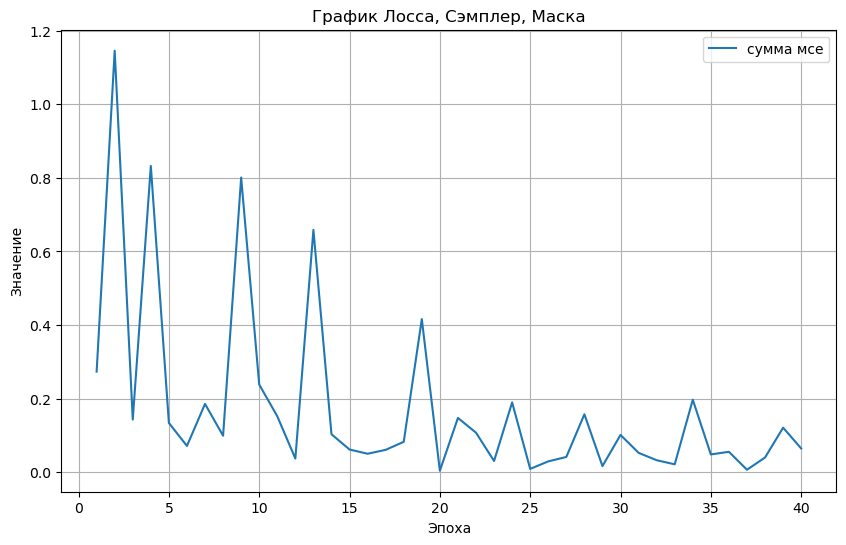

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Value'], label='сумма мсе')
plt.title('График Лосса, Сэмплер, Маска')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.grid(True)
plt.legend()
plt.show()

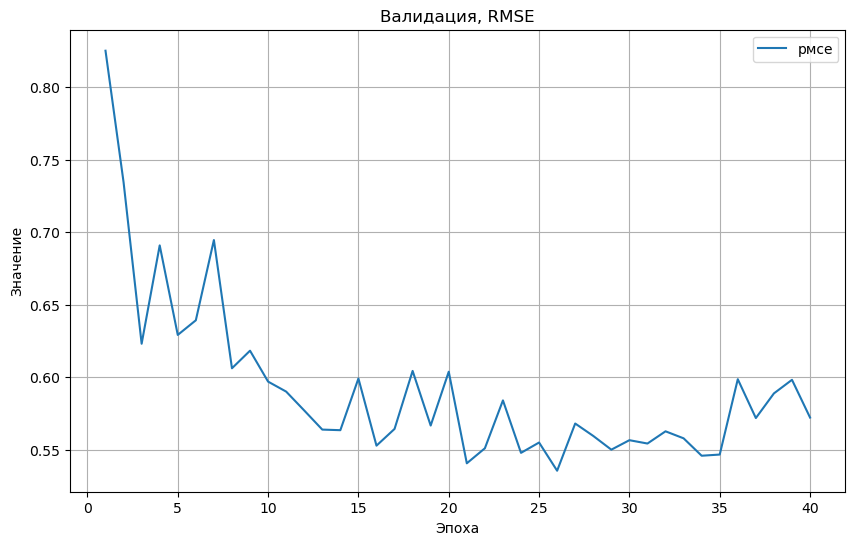

In [ ]:
df = pd.read_csv('csv (1).csv')
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Value'], label='рмсе')
plt.title('Валидация, RMSE')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.grid(True)
plt.legend()
plt.show()

Попробуем сделать через np.histogram и 5 бинов:

In [ ]:
def create_uniform_sampler(dataset):
    mos_scores = torch.tensor([d[1] for d in dataset.data], dtype=torch.float32)
    hist, bin_edges = np.histogram(mos_scores.numpy(), bins=5, density=True)
    bin_indices = np.digitize(mos_scores.numpy(), bin_edges[:-1]) - 1  # Индексы в гистограмме
    sample_weights = 1.0 / (hist[bin_indices] + 1e-8)  # Избегаем деления на 0
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler


In [ ]:
sampler = create_uniform_sampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=4, sampler=sampler, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda")
model = CNN_BLSTM_MBNET2().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 40
best_val_loss = float("inf")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs3/')

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []
    for spectrograms, mos_scores, mask, _ in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms, mos_scores, mask = spectrograms.to(device), mos_scores.to(device), mask.to(device)
        avg_scores, _ = model(spectrograms, mask)
        loss = criterion(avg_scores, mos_scores)
        writer.add_scalar('Loss/train', loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    val_loss = evaluate_model(model, test_dataloader, criterion)
    val = math.sqrt(val_loss)
    writer.add_scalar('RMSE/val', val, epoch)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} -  RMSE: {val:.4f}")
torch.save(model.state_dict(), os.path.join("IMSH", 'CNN_BLSTM_uniform_Sampler'))

Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:18<00:00,  4.72it/s]


Epoch 1/40 - Train Loss: 0.7064 -  RMSE: 0.6371


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 2/40 - Train Loss: 0.5134 -  RMSE: 0.6321


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.92it/s]


Epoch 3/40 - Train Loss: 0.4632 -  RMSE: 0.6433


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:09<00:00,  4.95it/s]


Epoch 4/40 - Train Loss: 0.4257 -  RMSE: 0.7383


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:07<00:00,  4.99it/s]


Epoch 5/40 - Train Loss: 0.3911 -  RMSE: 0.6218


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:00<00:00,  5.19it/s]


Epoch 6/40 - Train Loss: 0.3603 -  RMSE: 0.5993


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [02:59<00:00,  5.21it/s]


Epoch 7/40 - Train Loss: 0.3411 -  RMSE: 0.6464


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.91it/s]


Epoch 8/40 - Train Loss: 0.3220 -  RMSE: 0.6125


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:04<00:00,  5.08it/s]


Epoch 9/40 - Train Loss: 0.3060 -  RMSE: 0.5851


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:09<00:00,  4.95it/s]


Epoch 10/40 - Train Loss: 0.2992 -  RMSE: 0.5871


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:03<00:00,  5.09it/s]


Epoch 11/40 - Train Loss: 0.2843 -  RMSE: 0.5777


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.79it/s]


Epoch 12/40 - Train Loss: 0.2681 -  RMSE: 0.5606


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:10<00:00,  4.91it/s]


Epoch 13/40 - Train Loss: 0.2592 -  RMSE: 0.5825


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:20<00:00,  4.67it/s]


Epoch 14/40 - Train Loss: 0.2471 -  RMSE: 0.6601


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:07<00:00,  4.98it/s]


Epoch 15/40 - Train Loss: 0.2436 -  RMSE: 0.5946


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.85it/s]


Epoch 16/40 - Train Loss: 0.2360 -  RMSE: 0.5883


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:11<00:00,  4.88it/s]


Epoch 17/40 - Train Loss: 0.2183 -  RMSE: 0.6843


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 18/40 - Train Loss: 0.2111 -  RMSE: 0.5813


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.85it/s]


Epoch 19/40 - Train Loss: 0.2000 -  RMSE: 0.5695


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 20/40 - Train Loss: 0.1953 -  RMSE: 0.5783


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.81it/s]


Epoch 21/40 - Train Loss: 0.1873 -  RMSE: 0.5749


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:12<00:00,  4.86it/s]


Epoch 22/40 - Train Loss: 0.1837 -  RMSE: 0.5898


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 23/40 - Train Loss: 0.1724 -  RMSE: 0.5633


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 24/40 - Train Loss: 0.1693 -  RMSE: 0.5627


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:13<00:00,  4.83it/s]


Epoch 25/40 - Train Loss: 0.1636 -  RMSE: 0.5552


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:14<00:00,  4.82it/s]


Epoch 26/40 - Train Loss: 0.1570 -  RMSE: 0.5722


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:15<00:00,  4.78it/s]


Epoch 27/40 - Train Loss: 0.1534 -  RMSE: 0.5550


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.77it/s]


Epoch 28/40 - Train Loss: 0.1471 -  RMSE: 0.5773


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:16<00:00,  4.76it/s]


Epoch 29/40 - Train Loss: 0.1438 -  RMSE: 0.6215


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:22<00:00,  4.63it/s]


Epoch 30/40 - Train Loss: 0.1375 -  RMSE: 0.5584


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:21<00:00,  4.64it/s]


Epoch 31/40 - Train Loss: 0.1325 -  RMSE: 0.5687


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:08<00:00,  4.96it/s]


Epoch 32/40 - Train Loss: 0.1302 -  RMSE: 0.5455


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:05<00:00,  5.05it/s]


Epoch 33/40 - Train Loss: 0.1275 -  RMSE: 0.6264


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:32<00:00,  4.41it/s]


Epoch 34/40 - Train Loss: 0.1222 -  RMSE: 0.5493


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:28<00:00,  4.49it/s]


Epoch 35/40 - Train Loss: 0.1200 -  RMSE: 0.5618


Validation: 100%|███████████████████████████████████████████████████████████| 936/936 [03:17<00:00,  4.75it/s]


Epoch 36/40 - Train Loss: 0.1201 -  RMSE: 0.5705


Training Epoch 37:  92%|█████████████████████████████████████████████▉    | 3753/4089 [13:14<01:22,  4.09it/s]